## Important

`run_mafft.sh` and `run_raxml.sh` in each subfoloder of `Trees` to build the trees beforehand.

In [1]:
library(ape)
library(jsonlite)
library(sitePath)
library(ggplot2)
library(ggrepel)
library(aplot)
library(RColorBrewer)
suppressPackageStartupMessages(library(treeio))
suppressPackageStartupMessages(library(ggtree))

METADATA_DIR <- "Metadata"
TREES_DIR <- "Trees"
PLOTS_DIR <- "Plots"
STRUCTURES_DIR <- "Structures"
REFSEQ_DIR <- "RefSeq"

ZIKV_POLYPROTEIN_NAME <- "ZIKV_polyprotein"
SARS_COV_2_CDS_NAME <- "SARS_CoV_2_cds"
SARS_COV_2_REFERENCE = "EPI_ISL_402125"

Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 



### 1. ZIKV polyprotein

In [2]:
meta <- read.csv(
    file.path(METADATA_DIR, paste0(ZIKV_POLYPROTEIN_NAME, ".tsv")), 
    sep = "\t",
    row.names = "GenBank.Protein.Accession",
    na.strings = c("-N/A-", "Unknown"),
    stringsAsFactors = FALSE
)
rownames(meta) <- sapply(strsplit(rownames(meta), "\\."), "[", 1)
meta <- meta[, colSums(is.na(meta)) < nrow(meta)]

In [3]:
meta[which(meta[["Country"]] == "Taiwan"), ][["Country"]] <- "China"

In [4]:
treeDir <- file.path(TREES_DIR, ZIKV_POLYPROTEIN_NAME)
plotsDir <- file.path(PLOTS_DIR, ZIKV_POLYPROTEIN_NAME)
dir.create(plotsDir, showWarnings = FALSE)

In [5]:
tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

Warning message:
"`tbl_df()` is deprecated as of dplyr 1.0.0.
Please use `tibble::as_tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


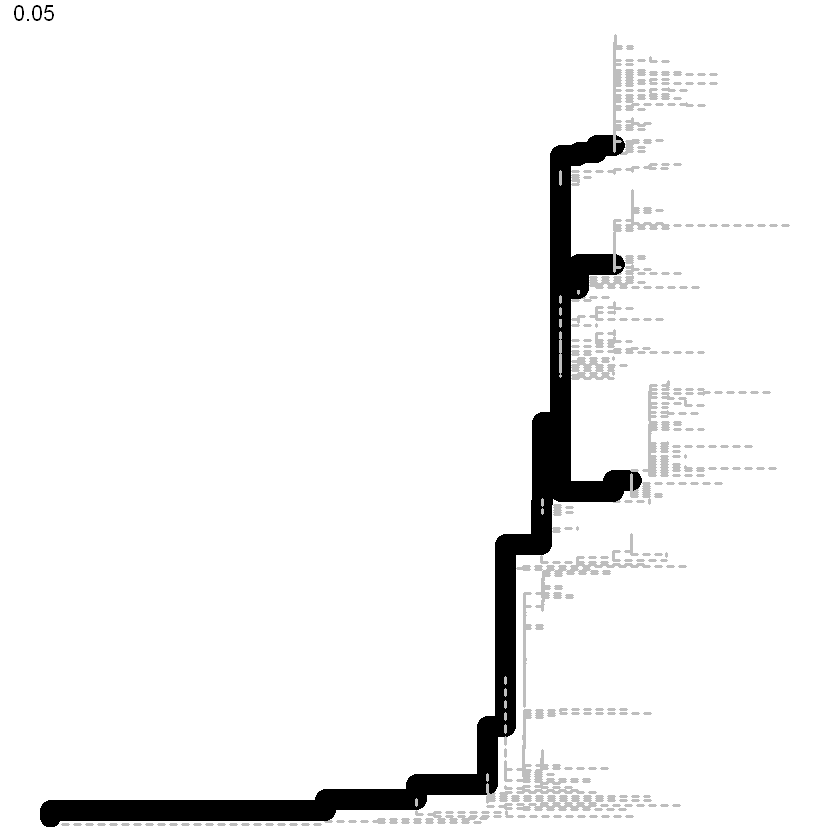

In [6]:
paths <- lineagePath(tree, 0.05)
plot(paths)

In [7]:
mutations <- fixationSites(paths)

Warning message:
"`mutate_()` is deprecated as of dplyr 0.7.0.
Please use `mutate()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


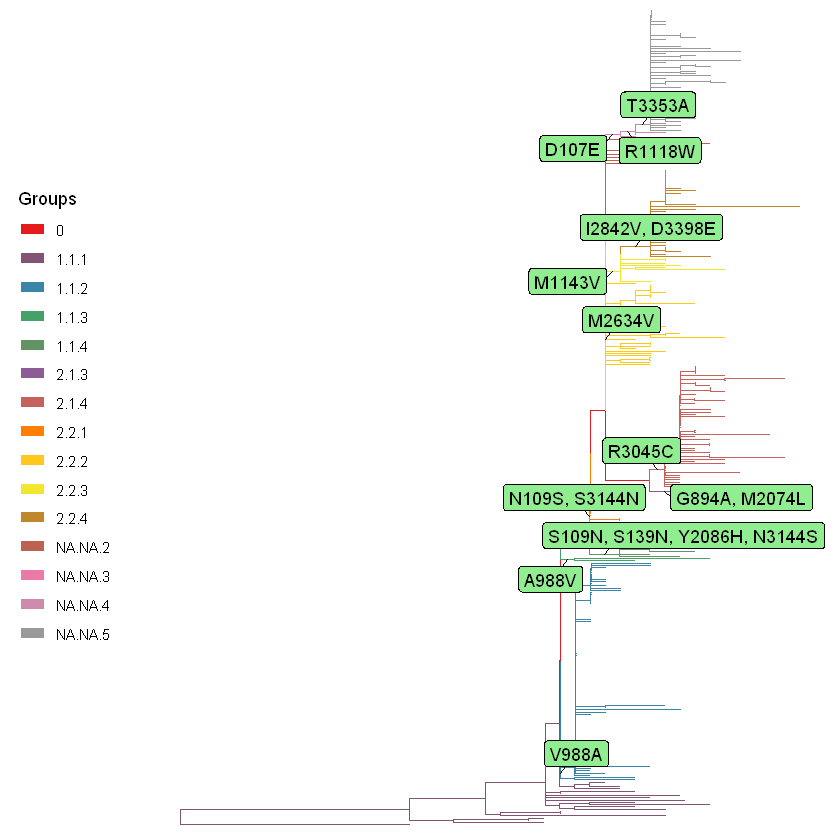

In [8]:
p <- plot(mutations)
p

ggsave(
    filename = file.path(plotsDir, "cluster.pdf"), 
    plot = p,
    width = 10,
    height = 8
)

In [9]:
pred <- as.data.frame(mutations)
write.csv(pred, file.path(plotsDir, "sitePath.csv"), row.names = FALSE)

In [10]:
snpTracing <- fixationPath(mutations)

In [11]:
tipClusters <- as.list(snpTracing)

In [12]:
countryData <- lapply(names(tipClusters), function(i) {
    tip <- tipClusters[[i]]
    data.frame(
        "tip" = i,
        "Country" = meta[as.phylo(tree)[["tip.label"]][tip], "Country"]
    )
})
countryData <- do.call(rbind, countryData)

In [13]:
df <- lapply(split(countryData, countryData[["Country"]]), function(i) {
    res <- reshape2::dcast(i, tip ~ Country, value.var = "Country", length)
    names(res)[2] <- "Num"
    res[["Country"]] <- unique(i[["Country"]])
    res
})
df <- do.call(rbind, df)

df <- df[order(df[["tip"]]), ]

df <- lapply(split(df, df[["tip"]]), function(i) {
    i[["Pos"]] <- cumsum(i[["Num"]]) - (0.5 * i[["Num"]])
    i
})
df <- do.call(rbind, df)
rownames(df) <- NULL

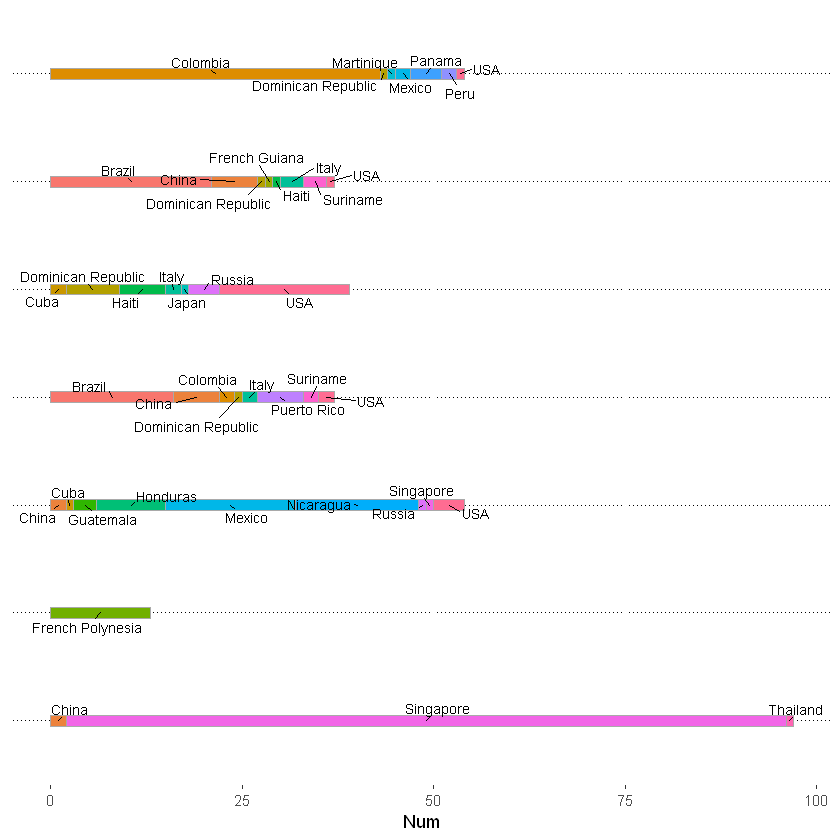

In [14]:
p1 <- ggplot(df, aes(x = Num, y = tip, fill = Country)) + 
    geom_bar(colour="#A9A9A9", stat="identity", position = position_stack(reverse = TRUE), width = 0.1) +
    geom_text_repel(
        aes(label=Country, x = Pos), 
        size = 3,
        min.segment.length = 0.1,
#         box.padding = 0.2,
#         direction = "y",
#         vjust = 1
    ) +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3),
        legend.position = "none"
    )
p1

Saving 14 x 6.67 in image



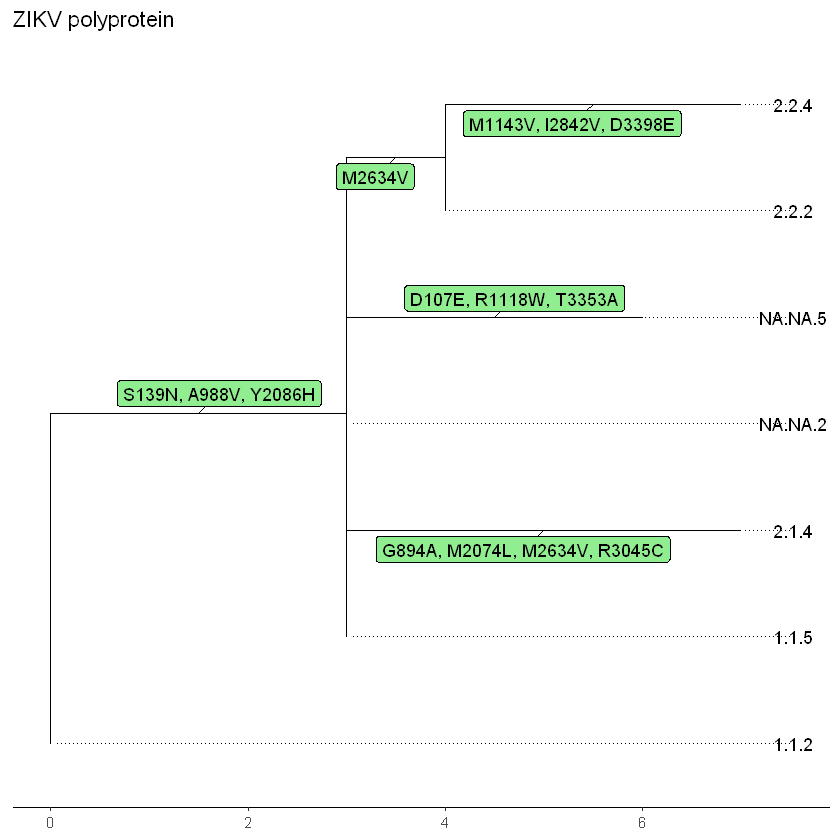

In [15]:
p <- plot(snpTracing) + ggtitle("ZIKV polyprotein")
p

p <- p1 %>% insert_left(p)

ggsave(filename = file.path(plotsDir, "snpTracing.pdf"), plot = p, width = 14)

### 2. SARS-CoV-2 CDS

In [16]:
treeDir <- file.path(TREES_DIR, SARS_COV_2_CDS_NAME)
plotsDir <- file.path(PLOTS_DIR, SARS_COV_2_CDS_NAME)
dir.create(plotsDir, showWarnings = FALSE)

In [17]:
cds2genome <- read_json(file.path(REFSEQ_DIR, paste0(SARS_COV_2_CDS_NAME, "2genome.json")), simplifyVector = TRUE)

In [18]:
meta <- read.csv(
    file.path(METADATA_DIR, paste0(SARS_COV_2_CDS_NAME, ".csv")), 
    row.names = "Accession.ID",
    stringsAsFactors = FALSE
)

In [19]:
tree <- read.tree(file.path(treeDir, "RAxML_bestTree.GTRGAMMA"))
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

In [20]:
tree <- setSiteNumbering(tree, SARS_COV_2_REFERENCE)

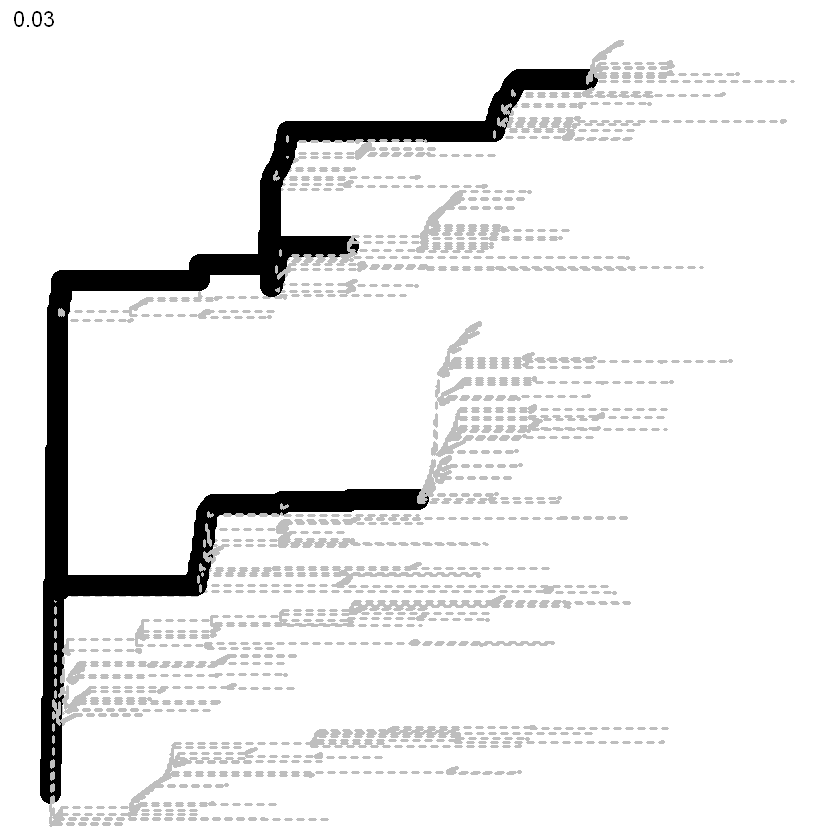

In [21]:
paths <- lineagePath(tree, similarity = 0.03)
plot(paths)

In [22]:
mutations <- fixationSites(paths)

In [23]:
setSiteNumbering.fixationSites <- function(x, reference, gapChar, ...) {
    site2newRef <- cds2genome
    names(x) <- vapply(
        X = names(x),
            FUN = function(n) {
            site2newRef[[n]]
            },
        FUN.VALUE = integer(1)
    )
    for (n in names(x)) {
        attr(x[[n]], "site") <- as.integer(n)
    }
    for (gpIndex in seq_along(attr(x, "clustersByPath"))) {
        for (i in seq_along(attr(x, "clustersByPath")[[gpIndex]])) {
            oldSiteName <- names(attr(attr(x, "clustersByPath")[[gpIndex]][[i]], "site"))
            names(attr(attr(x, "clustersByPath")[[gpIndex]][[i]], "site")) <- site2newRef[oldSiteName]
            toMergeRefSites <- attr(attr(x, "clustersByPath")[[gpIndex]][[i]], "toMergeRefSites")
            if (!is.null(toMergeRefSites)) {
                oldSiteName <- names(toMergeRefSites)
                names(attr(attr(x, "clustersByPath")[[gpIndex]][[i]], "toMergeRefSites")) <- site2newRef[oldSiteName]
            }
        }
    }
    return(x)
}

In [24]:
# print(attr(mutations, "clustersByPath"))

In [25]:
mutations <- setSiteNumbering(mutations)

In [26]:
pdf(file = file.path(plotsDir, "sites.pdf"))
for (i in mutations) {
    plot(i)
}
invisible(dev.off())

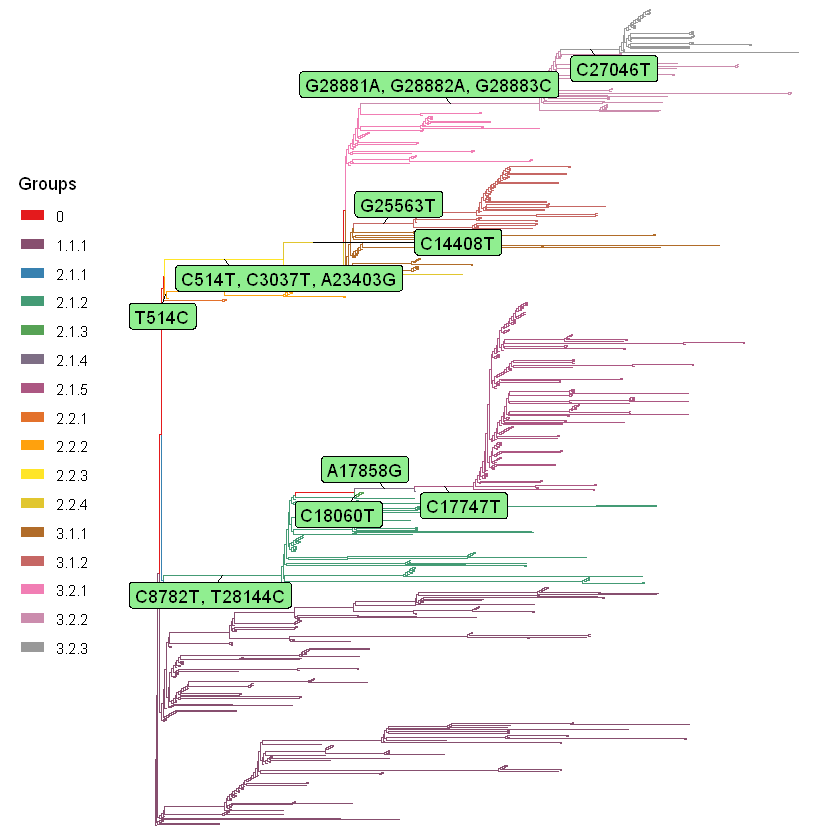

In [27]:
p <- plot(mutations)
p

ggsave(
    filename = file.path(plotsDir, "cluster.pdf"), 
    plot = p,
    width = 10,
    height = 8
)

In [28]:
pred <- as.data.frame(mutations)
write.csv(pred, file.path(plotsDir, "sitePath.csv"), row.names = FALSE)

In [29]:
pred <- as.data.frame(mutations, tipname = TRUE)
write.csv(pred, file.path(plotsDir, "sitePathTips.csv"), row.names = FALSE)

In [30]:
snpTracing <- fixationPath(mutations)

In [31]:
# attr(snpTracing, "SNPtracing")@data[["SNPs"]] <- sapply(
#     strsplit(attr(snpTracing, "SNPtracing")@data[["SNPs"]], ", "), 
#     function(allSNPs) {
#         if (anyNA(allSNPs)) {
#             return(allSNPs)
#         } else {
#             res <- sapply(allSNPs, function(snp) {
#                 charLen <- nchar(snp)
#                 preMut <- substr(snp, 1, 1)
#                 postMut <- substr(snp, charLen, charLen)
#                 site <- cds2genome[[substr(snp, 2, charLen - 1)]]
#                 return(paste0(preMut, site, postMut))
#             })
#             paste0(res, collapse = ", ")
#         }
# })

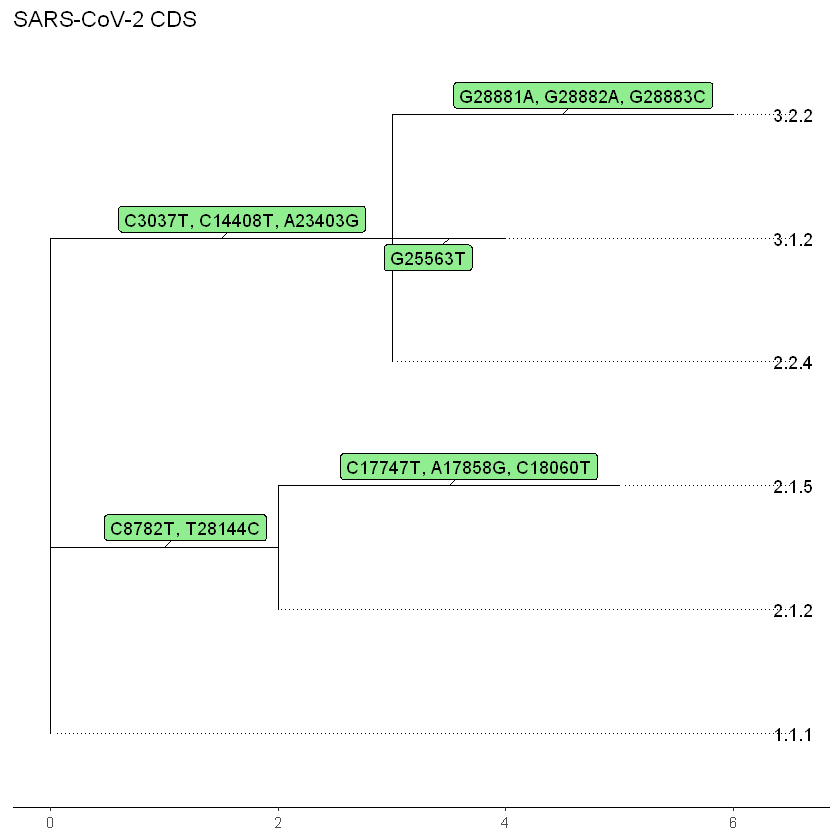

In [32]:
p <- plot(snpTracing) +
    ggtitle("SARS-CoV-2 CDS")
p

In [33]:
tipClusters <- as.list(snpTracing)

In [34]:
countryData <- lapply(names(tipClusters), function(i) {
    tip <- tipClusters[[i]]
    data.frame(
        "tip" = i,
        "Country" = meta[as.phylo(tree)[["tip.label"]][tip], "Country"]
    )
})
countryData <- do.call(rbind, countryData)

In [35]:
df <- lapply(split(countryData, countryData[["Country"]]), function(i) {
    res <- reshape2::dcast(i, tip ~ Country, value.var = "Country", length)
    names(res)[2] <- "Num"
    res[["Country"]] <- unique(i[["Country"]])
    res
})
df <- do.call(rbind, df)

df <- df[order(df[["tip"]]), ]

df <- lapply(split(df, df[["tip"]]), function(i) {
    i[["Pos"]] <- cumsum(i[["Num"]]) - (0.5 * i[["Num"]])
    i
})
df <- do.call(rbind, df)
rownames(df) <- NULL

Saving 14 x 6.67 in image



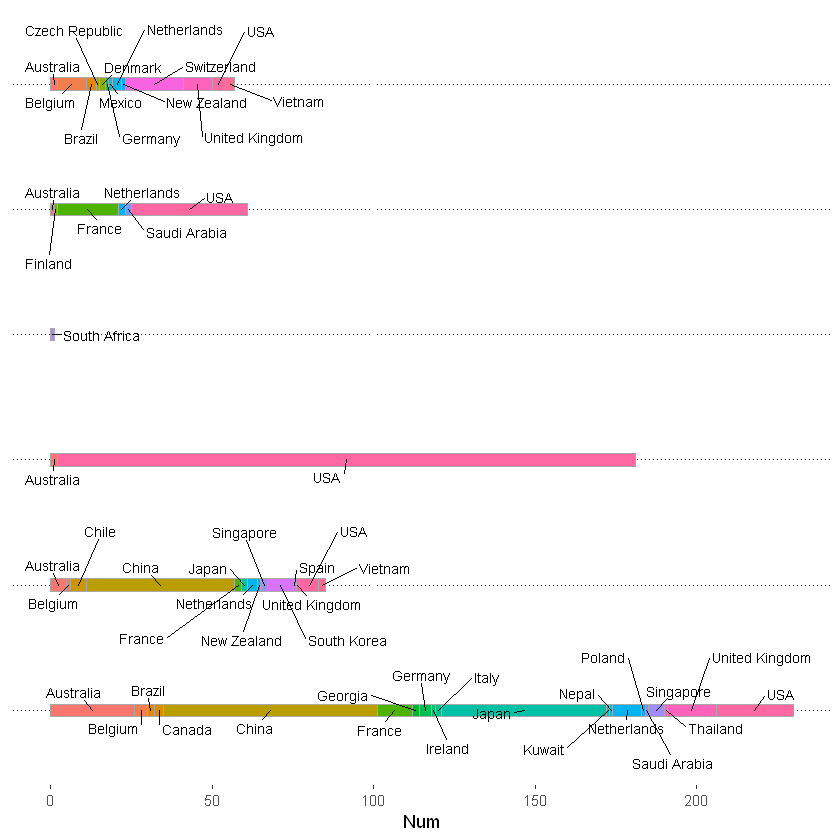

In [36]:
p1 <- ggplot(df, aes(x = Num, y = tip, fill = Country)) + 
    geom_bar(colour="#A9A9A9", stat="identity", position = position_stack(reverse = TRUE), width = 0.1) +
    geom_text_repel(
        aes(label=Country, x = Pos), 
        size = 3, 
        min.segment.length = 0.1,
        box.padding = 0.5
    ) +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3),
        legend.position = "none"
    )
p1

p <- p1 %>% insert_left(p)

ggsave(filename = file.path(plotsDir, "snpTracing.pdf"), plot = p, width = 14)

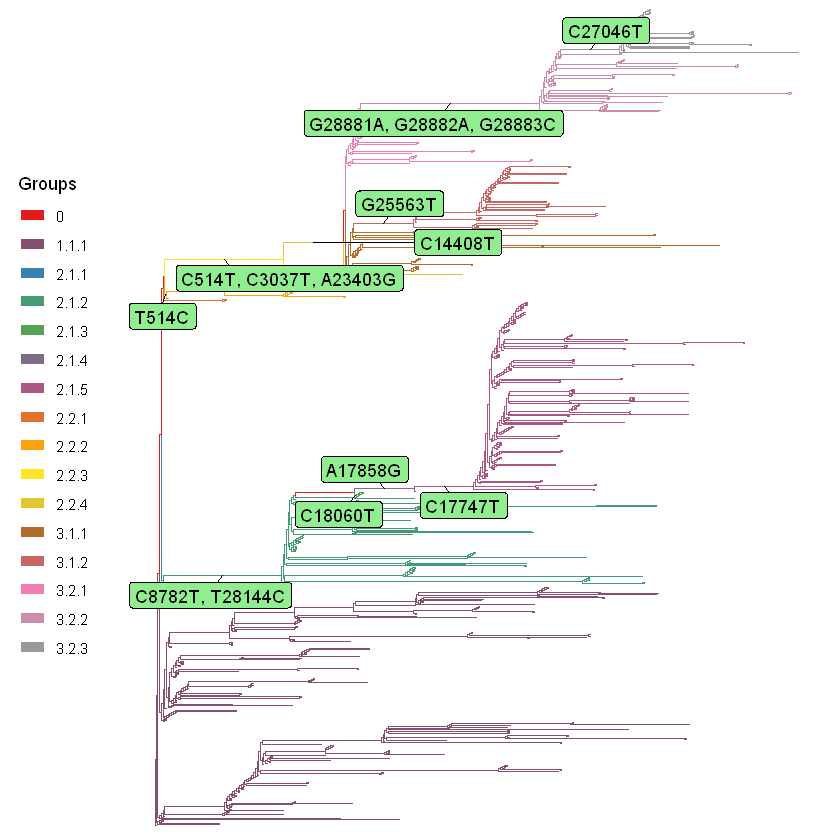

In [37]:
plot(mutations)